Indez
# 1 - Data preparation
* Load data
* Check for null or missing values
* Normalization
* Reshape
* Split into training an validation sets
* Data augmentation
# 2 - Model
* Define the model
* Optimizer
* Callbakcs
* Compile
# 3 - Evaluate the model
*   Training the model
*   Confusion matrix
# 4 - Predictions and final submission



In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


## 1 - Data preparation

### - Load data

In [ ]:
data_train = pd.read_csv('/train.csv')
data_train.head()

label  pixel0  pixel1  pixel2  ...  pixel780  pixel781  pixel782  pixel783
0      1       0       0       0  ...         0         0         0         0
1      0       0       0       0  ...         0         0         0         0
2      1       0       0       0  ...         0         0         0         0
3      4       0       0       0  ...         0         0         0         0
4      0       0       0       0  ...         0         0         0         0

[5 rows x 785 columns]

In [ ]:
data_test = pd.read_csv('/test.csv')
data_test.head()

pixel0  pixel1  pixel2  pixel3  ...  pixel780  pixel781  pixel782  pixel783
0       0       0       0       0  ...         0         0         0         0
1       0       0       0       0  ...         0         0         0         0
2       0       0       0       0  ...         0         0         0         0
3       0       0       0       0  ...         0         0         0         0
4       0       0       0       0  ...         0         0         0         0

[5 rows x 784 columns]

Divide the data_train into X_train anmd Y_ttrain ( label column).
Eliminate as well data_train variable for some free space

In [ ]:
y_train = data_train['label']
X_train = data_train.drop(labels = ['label'], axis = 1)

Plot the histogram in orden to see the distribution of values of y_train. It seems that there is a similar number os data for each number, so we can carry on.

(array([4132., 4684., 4177., 4351., 4072., 3795., 4137., 4401., 4063.,
        4188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

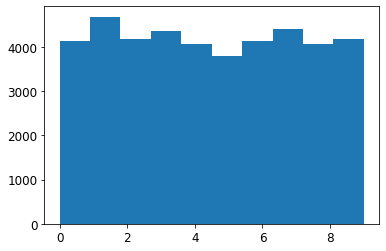

In [ ]:
plt.hist(y_train)

### - Check if there is any null value.

In [ ]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [ ]:
data_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### - Normalization
Normalize the data, as maximum value for pixel is 255

In [ ]:
X_train = X_train /255
data_test = data_test / 255

### - Reshape

In [ ]:
X_train = X_train.values.reshape(-1,28, 28,1)
data_test = data_test.values.reshape(-1,28,28,1)

### - Split into train, validation

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

### - Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

## 2 - Model

### - Create the CNN model

In [ ]:
# Create a Conv2D layer

from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")
# Create the model
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=9, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256, kernel_size=16),
    DefaultConv2D(filters=256, kernel_size=16),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128, kernel_size=9),
    DefaultConv2D(filters=128, kernel_size=9),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128, kernel_size=9),
    DefaultConv2D(filters=128, kernel_size=9),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=10, activation='softmax'),
])



### - Optimizer

In [ ]:
optimizer = keras.optimizers.Nadam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")


### - Callbacks

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("mnist_model_kaggle.h5", save_best_only=True)
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto',
    min_lr=0.00000001,
)
callbacks = [early_stopping_cb, model_checkpoint_cb, lr_reduction]

### - Compile

In [ ]:
# Compile the modelo

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"] )

## 3 - Evaluate the model

In [ ]:
history = model.fit(X_train, Y_train, 
                    epochs=10, 
                    validation_data=(X_val, Y_val),
                    callbacks=callbacks
                    )

Epoch 1/10
1050/1050 [==============================] - 132s 126ms/step - loss: 0.5066 - accuracy: 0.8228 - val_loss: 0.0908 - val_accuracy: 0.9746
Epoch 2/10
1050/1050 [==============================] - 132s 125ms/step - loss: 0.0832 - accuracy: 0.9775 - val_loss: 0.0573 - val_accuracy: 0.9845
Epoch 3/10
1050/1050 [==============================] - 132s 125ms/step - loss: 0.0534 - accuracy: 0.9868 - val_loss: 0.0543 - val_accuracy: 0.9855
Epoch 4/10
1050/1050 [==============================] - 133s 126ms/step - loss: 0.0444 - accuracy: 0.9885 - val_loss: 0.0492 - val_accuracy: 0.9858
Epoch 5/10
1050/1050 [==============================] - 132s 126ms/step - loss: 0.0367 - accuracy: 0.9909 - val_loss: 0.0458 - val_accuracy: 0.9880
Epoch 6/10
1050/1050 [==============================] - 133s 126ms/step - loss: 0.0299 - accuracy: 0.9929 - val_loss: 0.0373 - val_accuracy: 0.9902
Epoch 7/10
1050/1050 [==============================] - 132s 125ms/step - loss: 0.0233 - accuracy: 0.9945 - val_

In [ ]:
model.evaluate(X_train, Y_train)

1182/1182 [==============================] - 8s 6ms/step - loss: 0.0010 - accuracy: 0.9997


[0.0010109635768458247, 0.999656081199646]

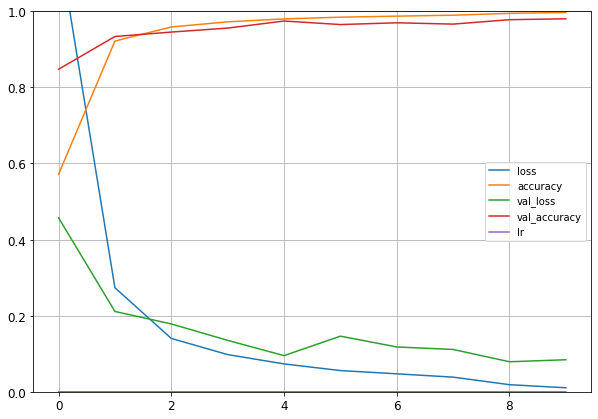

In [ ]:
pd.DataFrame (history.history).plot(figsize=(10,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## 4 - Prediction and submission


In [ ]:
predictions = model.predict(data_test)

Choose the maximun probability index

In [ ]:

predictions = np.argmax(predictions,axis = 1)

Create a pandas series with the predictions indexs

In [ ]:
results = pd.Series(predictions,name="Label")


Concat two series, one with the 1-28000, and the predictions

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen_2.csv",index=False)

In [ ]:
submission.shape

(28000, 2)